In [13]:
import os
import sys
import numpy as np
import tensorflow as tf
import input_data
import model_origin as model
import time 
import matplotlib.pyplot as plt

In [14]:
# you need to change the directories to yours.
train_dir = '../PetImages/train_convert/'
test_dir = '../PetImages/test/'
train_logs_dir = '../logs/train/'
val_logs_dir = '../logs/val'

N_CLASSES = 2
IMG_W = 208     # resize the image, if the input image is too large, training will be very slow.
IMG_H = 208
RATIO = 0.2     # take 20% of dataset as validation data
BATCH_SIZE = 64
CAPACITY = 2000
MAX_STEP = 4000 # with current parameters, it is suggested to use MAX_STEP>10k
learning_rate = 0.0001 # with current parameters, it is suggested to use learning rate<0.0001
models = {'origin':{}}

In [15]:
tf.reset_default_graph()

In [16]:
def training():
    
    train, train_label, val, val_label = input_data.get_files(train_dir, RATIO)
    train_batch, train_label_batch = input_data.get_batch(train,
                                                  train_label,
                                                  IMG_W,
                                                  IMG_H,
                                                  BATCH_SIZE,
                                                  CAPACITY)
    val_batch, val_label_batch = input_data.get_batch(val,
                                                  val_label,
                                                  IMG_W,
                                                  IMG_H,
                                                  BATCH_SIZE,
                                                  CAPACITY)
    
    #scale the float to -2.5 to 2.5
    train_batch = (1/(2*2.25)) * train_batch + 0.5
    
    x = tf.placeholder(tf.float32, shape=[BATCH_SIZE, IMG_W, IMG_H, 3])
    y_ = tf.placeholder(tf.int32, shape=[BATCH_SIZE])
#     CNN卷积操作
    logits = model.inference(x, BATCH_SIZE, N_CLASSES)
#    损失函数
    loss = model.losses(logits, y_)
#     梯度下降
    train_op = model.trainning(loss, learning_rate)
#     准确率
    acc = model.evaluation(logits, y_)


    
    with tf.Session() as sess:
        saver = tf.train.Saver()
        sess.run(tf.global_variables_initializer())
        coord = tf.train.Coordinator()
        threads = tf.train.start_queue_runners(sess= sess, coord=coord)
#         tensorboard查看
        summary_op = tf.summary.merge_all()
        train_writer = tf.summary.FileWriter(train_logs_dir, sess.graph)
        val_writer = tf.summary.FileWriter(val_logs_dir, sess.graph)

        steps_val = []
        accuracy_val = []
        loss_tr = []
        steps_tr = []
        accuracy_tr = []
        loss_val = []
        
        
        try:
            for step in np.arange(MAX_STEP):
                start = time.time()
                if coord.should_stop():
                        break
                tra_images,tra_labels = sess.run([train_batch, train_label_batch])
                _, tra_loss, tra_acc = sess.run([train_op, loss, acc],
                                                feed_dict={x:tra_images, y_:tra_labels})
                if step % 50 == 0:
                    print('Step %d, train loss = %.2f, train accuracy = %.2f%%' %(step, tra_loss, tra_acc*100.0))
                    summary_str = sess.run(summary_op,feed_dict={x:tra_images, y_:tra_labels})
                    steps_tr.append(step)
                    accuracy_tr.append(tra_acc)
                    loss_tr.append(tra_loss)
                    train_writer.add_summary(summary_str, step)

                if step % 50 == 0 or (step + 1) == MAX_STEP:
                    val_images, val_labels = sess.run([val_batch, val_label_batch])
                    val_loss, val_acc = sess.run([loss, acc],
                                                 feed_dict={x:val_images, y_:val_labels})
                    print('**  Step %d, val loss = %.2f, val accuracy = %.2f%%  **' %(step, val_loss, val_acc*100.0))
                    steps_val.append(step)
                    accuracy_val.append(val_acc)
                    loss_val.append(val_loss)
                    summary_str = sess.run(summary_op,feed_dict={x:val_images, y_:val_labels})
                    val_writer.add_summary(summary_str, step)

                if step % 2000 == 0 or (step + 1) == MAX_STEP:
                    checkpoint_path = os.path.join(train_logs_dir, 'model.ckpt')
                    saver.save(sess, checkpoint_path, global_step=step)
            time_used = time.time() - start
            models['origin'] = {'tr':{'steps_tr':steps_tr,'accuracy_tr':accuracy_tr,'tr_loss':loss_tr},
                                                  'val':{'steps_val':steps_val,'accuracy_val':accuracy_val,'val_loss':loss_val},
                                                  'times(s)':time_used}

        except tf.errors.OutOfRangeError:
            print('Done training -- epoch limit reached')
        finally:
            coord.request_stop()
        try:
            coord.join(threads)
        except:
            error_type, error_value, trace_back = sys.exc_info()
            print(error_value)


In [17]:
# 命令行输入: tensorboard  --logdir=/tmp/mnist 查看结果
# 浏览器输入:127.0.0.1:6006

In [18]:
# if __name__ == '__main__':
training()
# test_one_image()

There are 11309 cats
There are 11238 dogs
conv1:  (64, 208, 208, 16)
norm1:  (64, 104, 104, 16)
conv2:  (64, 104, 104, 16)
pool2:  (64, 104, 104, 16)
local3:  (64, 128)
local4:  (64, 128)
Step 0, train loss = 0.69, train accuracy = 45.31%
**  Step 0, val loss = 0.70, val accuracy = 45.31%  **
Step 1, train loss = 0.69, train accuracy = 46.88%
**  Step 1, val loss = 0.70, val accuracy = 40.62%  **
Step 2, train loss = 0.69, train accuracy = 46.88%
**  Step 2, val loss = 0.69, val accuracy = 51.56%  **
Step 3, train loss = 0.69, train accuracy = 46.88%
**  Step 3, val loss = 0.70, val accuracy = 39.06%  **
Step 4, train loss = 0.69, train accuracy = 46.88%
**  Step 4, val loss = 0.69, val accuracy = 46.88%  **


In [19]:
models

{'origin': {'times(s)': 31.071722745895386,
  'tr': {'accuracy_tr': [0.45312, 0.46875, 0.46875, 0.46875, 0.46875],
   'steps_tr': [0, 1, 2, 3, 4],
   'tr_loss': [0.69323778, 0.69444805, 0.69398701, 0.69323599, 0.69365609]},
  'val': {'accuracy_val': [0.45312, 0.40625, 0.51562, 0.39062, 0.46875],
   'steps_val': [0, 1, 2, 3, 4],
   'val_loss': [0.69632101, 0.69591451, 0.69306785, 0.69515502, 0.69406486]}}}

origin used: 31.071722745895386s


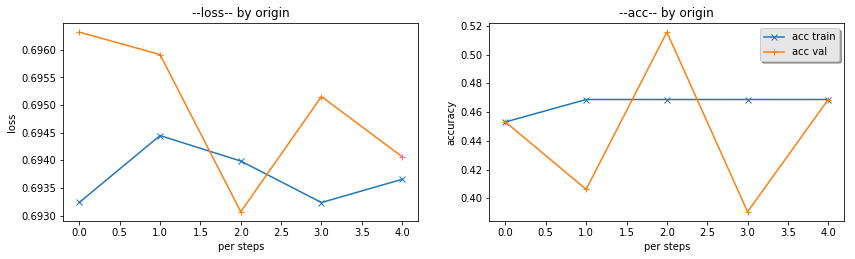

In [30]:
# 绘制loss的曲线
plt.figure(figsize=(14,8))
print('origin used: '+ str(models['origin']['times(s)']) + 's')
plt.subplot(221)
plt.plot(models['origin']['tr']['steps_tr'],models['origin']['tr']['tr_loss'],"x-",label='train')
plt.plot(models['origin']['val']['steps_val'],models['origin']['val']['val_loss'],"+-",label='val')
plt.ylabel('loss')
plt.xlabel('per steps')
plt.title('--loss-- by origin')


plt.subplot(222)
plt.plot(models['origin']['tr']['steps_tr'],models['origin']['tr']['accuracy_tr'],"x-",label='acc train')
plt.plot(models['origin']['val']['steps_val'],models['origin']['val']['accuracy_val'],"+-",label='acc val')
plt.ylabel('accuracy')
plt.xlabel('per steps')
plt.title('--acc-- by origin')


legend = plt.legend(loc='best',shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')
plt.show()